a few steps:
    
    -find representative nodes 
            1. feature extraction (all the followees)  
            2. feature selection  
                modify here 10/31/2016
                (1) instead of get the top 300 most counts, now weed out 1 and 2 get all followees. query their total followers
                (2) instead of penalize by total followers, consider penalize by a prior distribution 1 - p(target users)
     my feeling on this section, there wont be many improvement available. Cuz we only have positive features, feature selection methods (mutual information, chi2, f-test wont work, already tested)
            
    -classification/ranking based on the feature
    -testing
    
    -addition: besides follower/followee relationship, whatelse information can we add into this model
    

In [3]:
import tweepy
import json
from time import sleep
import pickle
import re
from os import listdir
from os.path import isfile, join
import sys
import math
%matplotlib inline
import matplotlib.pyplot as plt

# configuration

In [4]:
path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\CS597\\twitterMining\\'
initialSet_path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\'
path_test1 = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\test1\\'

In [5]:
config = {}
config['KEYS'] = {'consumer_key': ['mVJcyNN5qFyk7GdBJvENVc329', 'anqjETSjwaDqA9LBt0MGwub60','vDnzvZFFwXFgI2ftQxYWV2XZo',
                                  'sAkNaJxJWgPilhidaNJ48kmCo','tO2Bzbkexyf57LSF6aJwACXfs'],
                  'consumer_secret': ['DbXUXB7EN77HmzQahobHeTPSWgcNI9t8kKzDoe5twfTORnjXxf',\
                                       'AGTAiJhOrb2gPSbW1F5Rclu0Ns7pTZthPhJ3i7ySFNWwdheqim',\
                                     '5HxLPob3kGqgauc5HuNszFw0uoLjsK3JHD0IqUNEVbNAIVdRKQ',\
                                      'dPcVmoYaEGhsWC5djrEFsjfNdO8DmFecmSnBRjL63y0Sg9pCtl',
                                     'OIEIE1Pu01eTieDffG13kJM78spAPHZtKk2IZ1yGkU0eoKvVxn'],
                  'access_token': ['707770026573561856-Vfqm0iXrsBvFL2prQMQ2Gzu9eawWYIj',\
                                    '707770026573561856-diXgIsR0UCYM3CHYCUoU38hcp8Qk8Pj',\
                                  '707770026573561856-9BcLFzjLrkVdxeG0Z3dmqYhsCDqUQ2t',\
                                  '707770026573561856-Sua2gUtlWTxTik70a0dUba0SvayeQgU',\
                                  '707770026573561856-Oi1nNb4Ih0SJyizIwToY3PhjLymGkcl'],
                  'access_token_secret': ['HSMqS4YkDBcB6mm9JL3vd6VeKlkKmNdMxmJ0inJQwNhXS',\
                                           'GnqrY0AoeOuK7cgaF2yRBmcJGcc814bBIONMREN8gU7xu',\
                                         'e2OfQnQGnweLygFxJRFCUa9PZhOZXyCcaEipMpnlmABqj',\
                                         'Stj2TQtwsrTQFkdronpZDUyrl9g3slZjEMxgIYznbmSzy',\
                                         'Cp3d4xKdTfPyJq6y7uLeRLv77kTjZmEIpGYtiWrrqvK6i']
                 }
''
# later add {if it's not exist then write, otherwise skip}
with open(path + "CONFIG_PATH.pickle", 'wb+') as f:
        pickle.dump(config, f)

In [6]:
consumer_key = config['KEYS']['consumer_key']    # list
consumer_secret = config['KEYS']['consumer_secret']
access_token = config['KEYS']['access_token']
access_token_secret = config['KEYS']['access_token_secret']

# use to collect location

In [9]:
def gather_location(candidate_id):
    
    try:
        location = api.get_user(str(candidate_id)).location
        
        if location == '':
            location = 'NaN'
        
        return location
    
    except:
        print('error')
        pass
    
        return 'NaN'

In [75]:
with open(path_test1 + 'candidate_sp2.pickle','rb') as f:
    candidate_sp2 = pickle.load(f)

In [98]:
auth = tweepy.OAuthHandler(consumer_key[2], consumer_secret[2])
auth.set_access_token(access_token[2], access_token_secret[2])
api = tweepy.API(auth, wait_on_rate_limit= True,wait_on_rate_limit_notify=True)

In [90]:
auth = tweepy.OAuthHandler(consumer_key[0], consumer_secret[0])
auth.set_access_token(access_token[0], access_token_secret[0])
api = tweepy.API(auth, wait_on_rate_limit= True,wait_on_rate_limit_notify=True)

In [92]:
auth = tweepy.OAuthHandler(consumer_key[1], consumer_secret[1])
auth.set_access_token(access_token[1], access_token_secret[1])
api = tweepy.API(auth, wait_on_rate_limit= True,wait_on_rate_limit_notify=True)

In [94]:
auth = tweepy.OAuthHandler(consumer_key[3], consumer_secret[3])
auth.set_access_token(access_token[3], access_token_secret[3])
api = tweepy.API(auth, wait_on_rate_limit= True,wait_on_rate_limit_notify=True)

In [96]:
auth = tweepy.OAuthHandler(consumer_key[4], consumer_secret[4])
auth.set_access_token(access_token[4], access_token_secret[4])
api = tweepy.API(auth, wait_on_rate_limit= True,wait_on_rate_limit_notify=True)

In [79]:
location_dict_sp2 = {}
len(candidate_sp2)

9809

In [99]:
for c in candidate_sp2[9000:9809]:
    location_dict_sp2[c] = gather_location(c)
with open(path_test1 + 'location_list_sp2.pickle','wb+') as f:
    pickle.dump(location_dict_sp2, f)

len(location_dict_sp2)

9809

# test whether the ranking predictive model works

<p>seperate them into groups: baseline(twitter stream), every 300? </p>
<p>we should see there is a decline in matching accuracy in the two aspects: eg.football + chicago </p>

<p> 1. chicago </p>
<b> ratio = # user from chicago / # number of user provide their location </b>



In [46]:
# a bag of pre-defined locations that represent chicago
chicago = ['chicago','Arlington Heights', 'Aurora', 'Berwyn', 'Bolingbrook', 'Cicero','Des Plaines', 'Elgin','Evanston', 'Gary', 'Hammond',
           'Hoffman Estates', 'Joliet', 'Kenosha', 'Mount Prospect','Naperville', 'Oak Lawn', 'Oak Park', 'Orland Park',
           'Palatine', 'Schaumburg','Skokie','Tinley Park','Waukegan','Wheaton']#,', IL','Illinois']

In [57]:
def print_ratio(candidate_list,location_list, area, interval,path,title,verbose=False):
    
    ratio = []
    
    for i in range(math.floor(len(candidate_list)/interval)):
        if verbose == True:
            print('bin:',interval*(i), '~', interval*(i+1))
        
        target_count = 0
        general_count = 0
        no_count = 0
        
        for cand in candidate_list[interval*(i): interval*(i+1)]:
            if location_list[cand[0]] != 'NaN' and location_list[cand[0]] != None:
                general_count += 1
                #print('g',general_count,loc)
                flag = False
                for a in area:
                    if location_list[cand[0]].lower().find(a.lower()) != -1: 
                        # matches one of the place that stands for chicago
                        flag = True
            
                if flag == True:
                    target_count += 1
                    #print('t',target_count,loc)
            else:
                no_count += 1                
        
        if verbose == True:
            print("% of people provide location : ", general_count/(interval)*100, '%')
        
        if general_count !=0:
            if verbose == True:
                print("% of people from chicago who provided location: ", target_count/general_count*100, '%\n')
            ratio.append(target_count / general_count)
        else:
            if verbose == True:
                print("invalid bin\n")
            ratio.append('NaN')
            
    
    x = range(len(ratio))
    y = ratio

    fig, axes = plt.subplots(figsize=(5,5))

    axes.bar(x,y)
    axes.set_xlabel('ranked group with an interval of ' + str(interval), fontsize = 8)
    axes.set_ylabel('percentage of user from chicago',fontsize = 8)
    axes.set_title(title,fontsize = 10)

    plt.show()  
    
    fig.savefig(path + title + ' ' + str(interval) + '.png')
            

    return ratio

In [7]:
with open(path_test1 + 'location_list_sp1.pickle','rb') as f:
    location_dict_sp1 = pickle.load(f)

# test cosine similarity rank (weighted)

In [39]:
with open(path_test1 + 'weighted_sim_rank_sp1.pickle','rb') as f:
    candidate_sim = pickle.load(f)

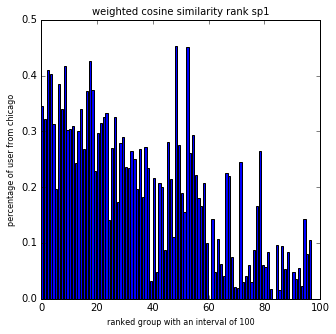

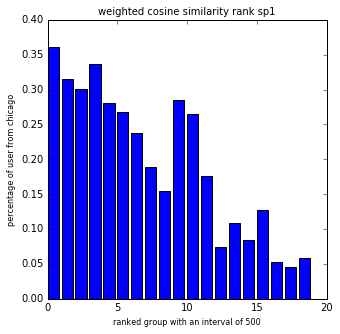

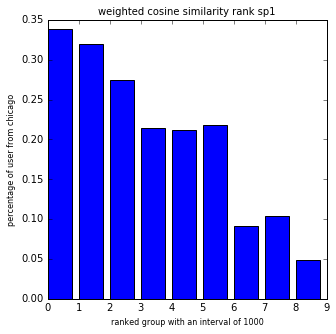

In [58]:
ratio = print_ratio(candidate_sim, location_dict_sp1, chicago, interval = 100, path = path_test1,\
                    title = 'weighted cosine similarity rank sp1',verbose = False)
ratio = print_ratio(candidate_sim, location_dict_sp1, chicago, interval = 500, path = path_test1,\
                    title = 'weighted cosine similarity rank sp1',verbose = False)
ratio = print_ratio(candidate_sim, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
                    title = 'weighted cosine similarity rank sp1',verbose = False)

# test unweighted cosine similarity

In [59]:
with open(path_test1 + 'unweighted_sim_rank_sp1.pickle','rb') as f:
    u_candidate_sim = pickle.load(f)

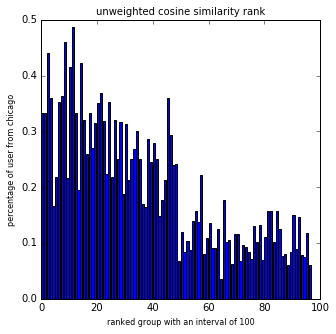

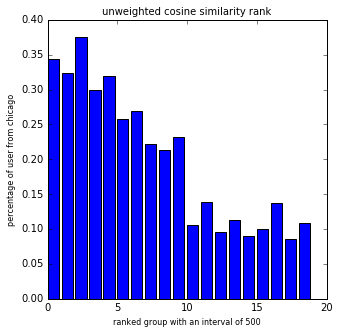

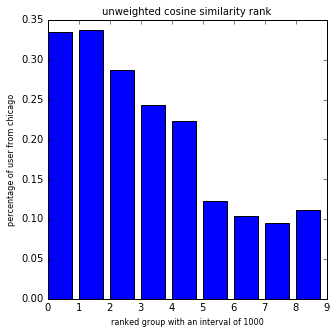

In [60]:
ratio = print_ratio(u_candidate_sim, location_dict_sp1, chicago, interval = 100, path = path_test1,\
                    title = 'unweighted cosine similarity rank',verbose = False)
ratio = print_ratio(u_candidate_sim, location_dict_sp1, chicago, interval = 500, path = path_test1,\
                    title = 'unweighted cosine similarity rank',verbose = False)
ratio = print_ratio(u_candidate_sim, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
                    title = 'unweighted cosine similarity rank',verbose = False)

# test NB ranking w/ penalty

In [62]:
with open(path_test1 + 'NB_rank_sp1.pickle','rb') as f:
    candidate_NB = pickle.load(f)
with open(path_test1 + 'NB_p_rank_sp1.pickle','rb') as f:
    candidate_NB_p = pickle.load(f)    

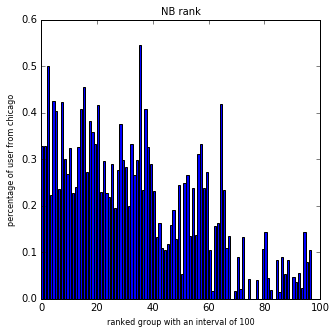

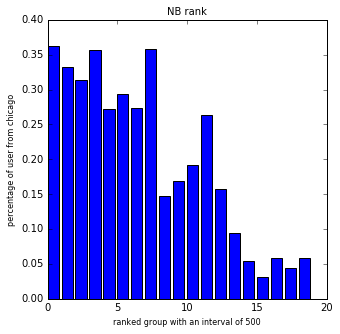

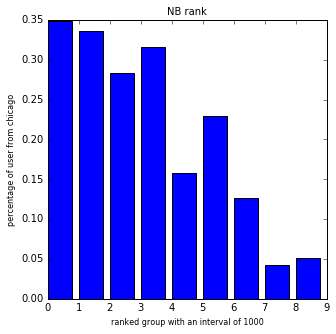

In [64]:
ratio = print_ratio(candidate_NB, location_dict_sp1, chicago, interval = 100, path = path_test1,\
                    title = 'NB rank',verbose = False)
ratio = print_ratio(candidate_NB, location_dict_sp1, chicago, interval = 500, path = path_test1,\
                    title = 'NB rank',verbose = False)
ratio = print_ratio(candidate_NB, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
                    title = 'NB rank',verbose = False)

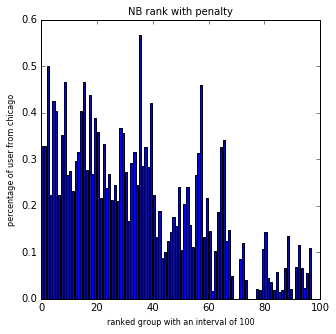

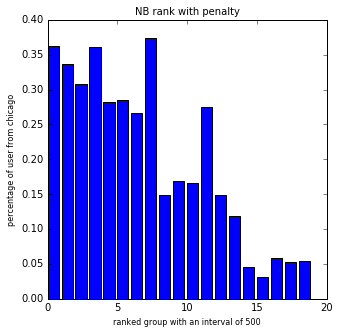

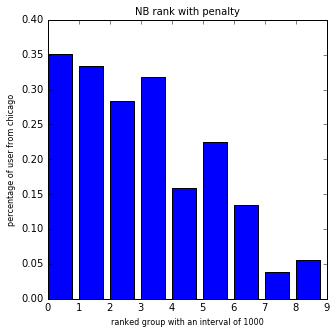

In [65]:
ratio = print_ratio(candidate_NB_p, location_dict_sp1, chicago, interval = 100, path = path_test1,\
                    title = 'NB rank with penalty',verbose = False)
ratio = print_ratio(candidate_NB_p, location_dict_sp1, chicago, interval = 500, path = path_test1,\
                    title = 'NB rank with penalty',verbose = False)
ratio = print_ratio(candidate_NB_p, location_dict_sp1, chicago, interval = 1000, path = path_test1,\
                    title = 'NB rank with penalty',verbose = False)

# Average Precision on a ranked list AVP(L)  
<img src = 'AVP.png'>

In [70]:
def av_precision(candidate_list,location_list, area):
    
    relevant = 0
    total_score = 0
    count = 0
    
    for cand in candidate_list:
            
            if location_list[cand[0]] != 'NaN' and location_list[cand[0]] != None:
                count += 1  #people who provide the ground truth
                
                flag = False
                for a in area:
                    if location_list[cand[0]].lower().find(a.lower()) != -1: 
                        # matches one of the place that stands for chicago (Relevant)
                        flag = True
                if flag == True:
                    relevant += 1
                    total_score  += relevant/count
    print('rel:', relevant)
    avp = total_score/relevant
    
    return avp

In [74]:
w_sim_score = av_precision(candidate_sim,location_dict_sp1, chicago)
u_sim_score = av_precision(u_candidate_sim,location_dict_sp1,chicago)
NB_score = av_precision(candidate_NB,location_dict_sp1,chicago)
NB_p_score = av_precision(candidate_NB_p,location_dict_sp1,chicago)
print("average precision sample 1 (test on location match)")
print('weighted cosine similarity method:\t',w_sim_score)
print('unweighted cosine similarity method:\t',u_sim_score)
print('Naive Bayes method:\t\t\t',NB_score)
print('Naive Bayes with penalty method:\t',NB_p_score)

rel: 907
rel: 907
rel: 907
rel: 907
average precision sample 1 (test on location match)
weighted cosine similarity method:	 0.3059144596993453
unweighted cosine similarity method:	 0.30009042429464794
Naive Bayes method:			 0.3144313068005247
Naive Bayes with penalty method:	 0.31427365532158713


# test classification (use sample 1 location list)

1. Naive Bayes classification

In [58]:
def clf_chicago_percentage(id_list,location_list,area):
    
    general_count = 0
    target_count = 0
    
    for id in id_list:
        
        if location_list[id] != None and location_list[id] != 'NaN':
            general_count += 1
            
            flag = False
            for a in area:
                if location_list[id].lower().find(a.lower()) != -1: 
                    
                    # matches one of the place that stands for chicago
                    flag = True
            
            if flag == True:
                target_count += 1
                # print(location_list[id])
                    
    print("how many user provide location: ", general_count)
    print("how many user are from target area: ", target_count)
    print("accuracy = ", target_count/general_count)
    
    return target_count, general_count

# Naive Bayes

In [60]:
with open(path_test1 + 'clf_NB_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(path_test1 + 'clf_NB_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)

print("id marked true")
t1,g1 = clf_chicago_percentage(rel_id_test,location_dict_sp1,chicago)
print('\n')
print("id marked false")
t2,g2 = clf_chicago_percentage(irrel_id_test,location_dict_sp1,chicago)

id marked true
how many user provide location:  403
how many user are from target area:  145
accuracy =  0.3598014888337469


id marked false
how many user provide location:  3447
how many user are from target area:  582
accuracy =  0.16884247171453437


# Decision Tree

In [61]:
with open(path_test1 + 'clf_DT_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(path_test1 + 'clf_DT_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)

print("id marked true")
clf_chicago_percentage(rel_id_test,location_dict_sp1,chicago)
print('\n')
print("id marked false")
clf_chicago_percentage(irrel_id_test,location_dict_sp1,chicago)

id marked true
how many user provide location:  331
how many user are from target area:  93
accuracy =  0.2809667673716012


id marked false
how many user provide location:  3519
how many user are from target area:  634
accuracy =  0.1801648195510088


(634, 3519)

# KNN (neighbor = 1)

In [62]:
with open(path_test1 + 'clf_KNN_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(path_test1 + 'clf_KNN_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)

print("id marked true")
clf_chicago_percentage(rel_id_test,location_dict_sp1,chicago)
print('\n')
print("id marked false")
clf_chicago_percentage(irrel_id_test,location_dict_sp1,chicago)

id marked true
how many user provide location:  331
how many user are from target area:  104
accuracy =  0.31419939577039274


id marked false
how many user provide location:  3519
how many user are from target area:  623
accuracy =  0.17703893151463485


(623, 3519)

# SVM

# Gradient Boosting Classification

In [86]:
with open(path_test1 + 'clf_GBC_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(path_test1 + 'clf_GBC_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)

print("id marked true")
clf_chicago_percentage(rel_id_test,location_dict_sp1,chicago)
print('\n')
print("id marked false")
clf_chicago_percentage(irrel_id_test,location_dict_sp1,chicago)

id marked true
how many user provide location:  116
how many user are from target area:  47
accuracy =  0.4051724137931034


id marked false
how many user provide location:  3734
how many user are from target area:  680
accuracy =  0.1821103374397429


(680, 3734)

# Neural Network classficiation (Hidden layer 100? all default setting)

In [71]:
with open(path_test1 + 'clf_NNW_test_rel.pickle','rb') as f:
    rel_id_test = pickle.load(f)
with open(path_test1 + 'clf_NNW_test_irrel.pickle','rb+') as f:
    irrel_id_test = pickle.load(f)

print("id marked true")
clf_chicago_percentage(rel_id_test,location_dict_sp1,chicago)
print('\n')
print("id marked false")
clf_chicago_percentage(irrel_id_test,location_dict_sp1,chicago)

id marked true
how many user provide location:  174
how many user are from target area:  49
accuracy =  0.28160919540229884


id marked false
how many user provide location:  3676
how many user are from target area:  678
accuracy =  0.18443960826985853


(678, 3676)